Diederik de Wit - 0829667

Daphne Miedema - 0771425

# Assignment 2

***

## Question 1: Neural Codes & Nearest Neighbor retrieval (7.5pt)
The Caltech101 dataset consists of images of 101 different objects. In this question you will develop an image retrieval system using image representations (neural codes) learned with a deep convolutional neural network and a given distance metric.

In the tasks below you will need to implement the following steps:

* Retrieval for $n$ selected (distinct) query images from the dataset
    * For each query image, obtain the 5 most similar images (excluding the query image itself!)
* Evaluation of the quality of the retrieval 
    * The Caltech101 images are annotated with their object class. Use these annotations to evaluate the accuracy of the retrieval task.
    * For each query image, count the number of images whose class corresponds to the one from the query. The score of the retrieval for that image then ranges between:
        * **5** *all* retrieved images' classes agree with the query image class
        * **0** *none* of the images' classes agree with the query image class
    * Compute the average of all $n$ queries

***

### Task 1.1:  Neural codes image retrieval
**a)** Implement the retrieval task and evaluate the results for $n=200$ images. Use the provided VGG16 network pre-trained on ImageNet to compute "neural codes" and L2-distance. Specifically use the codes produces by the following layers of the model: 
1. the "fc1"-layer
2. the "fc2"-layer

Provide the retrieval evaluation scores for both tasks.

In [20]:
# you'll need these imports:
from keras.preprocessing import image
from sklearn.neighbors import NearestNeighbors
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py

In [3]:
# NOTE: you will first need to apply some changes to "Practical-3.3.0_preprocess-caltech101.ipynb" and run it
#       to obtain a pickle file with "fc1"-features. You don't need to show these changes here.


# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

def show_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
    
# iterate over two data representations (make sure these two files exist in the "data" subfolder first)
for datapath in ("caltech101_VGG16_fc1.p", "caltech101_VGG16_fc2.p"):
    # load the dataset
    with open(os.path.join("data", datapath), "rb") as f:
        X_fc, y, X_paths, classes = pickle.load(f)


    # === SOLUTION: ===    
    neigh = NearestNeighbors(n_neighbors=6, p=2)
    neigh.fit(X_fc)
    X = X_fc[indices]
    nn = neigh.kneighbors(X)
    average = 0
    # Iterate over the instances.
    for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
        # Find the original and its properties
        original_class = classes[y[i]]
        # Don't start at zero, because the first neighbor is the original.
        score = -1
        for dist, j in zip(distances, nn_indices):
            if(classes[y[j]] == original_class):
                score += 1
        average = average + score
    average = average/n
    print("(Datapath: {}, average score: {})".format(datapath, average))


(Datapath: caltech101_VGG16_fc1.p, average score: 3.7)
(Datapath: caltech101_VGG16_fc2.p, average score: 3.985)


***

**b)** Which representation ("neural code") provided better features for the given retrieval task? 
Justify your answer and discuss possible reasons for the observed results. Relate your answer to the conclusions in the paper "Neural Codes for Image Retrieval".

**Answer:**

As reflected in the scores calculated above, it seems that the fc2 layer representations perform a bit better on the retrieval tasks. The scores depend on the images that are chosen, but overall, fc2 consistently scores higher.

When we relate this code to the Babenko et al. paper, it looks like fc1 and fc2 from VCC16 would correspond to their L6 and L7, the final two fully connected layers before the output. The results of Babenko et al. show the best performance at L6, two levels below the outputs. We, on the other hand, found the best performance in fc2, on layer below the outputs, with worse performance for fc1 which is two layers below the outputs.

Babenko et al. speculate that this is because the top layers are tuned too much for the classification task, whereas they perform a retrieval task. Our experiment on the other hand, does involve a classification task. The network was not trained on the dataset it classified in both cases, so there should be no difference in that sense. The Keras VGG16 implementation was trained on Imagenet, but evaluated on Caltech101. From this we conclude that the difference in most effective layer must be due to the different tasks performed in Babenko et al. versus this assignment.

***

### Task 1.2: Detailed evaluation
**a)** The retrieval scores can vary from one query image to another. Some images are quite representative and for them retrieval works well, some are not so much.
For the same retrieval task given above using "fc2"-features, find (if possible) six query images such that they range from excellent to poor retrieval performance. More specifically find example query images that result in query scores of exactly 0, 1, 2, 3, 4, and 5.

Visualise the six (or less) resulting query images.

In [21]:
# you'll need these extra imports:
from keras.preprocessing import image
import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
# load the dataset
datapath = "caltech101_VGG16_fc2.p"
with open(os.path.join("data", datapath), "rb") as f:
    X_fc, y, X_paths, classes = pickle.load(f)

# you can use this simple function to visualise an image, given a filepath
def show_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.show()
# example usage given some index < 8677:
#index = 254
#show_img(X_paths[index])


# === SOLUTION: ===
neigh = NearestNeighbors(n_neighbors=6, p=2)
neigh.fit(X_fc)
    
scores = [0, 1, 2, 3, 4, 5]

def find_Score(index):
    nn = neigh.kneighbors(index)
    score = 0
    for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
        # Find the original and its properties
        original_class = classes[y[i]]
        for dist, j in zip(distances, nn_indices):
            if(classes[y[j]] == original_class):
                score += 1
    return score

while len(scores) > 0: 
    # find a random index
    index = np.random.choice(range(n_examples), size=1, replace=False)
    # Calculate the corresponding score
    newScore = find_Score(X_fc[index])
    # If that score was not found already, remove it
    if newScore in scores: 
        scores.remove(newScore)
        print("Index: {} retrieved score of: {}".format(index, newScore))
        print("New list is: {}".format(scores))

Index: [2535] retrieved score of: 0
New list is: [1, 2, 3, 4, 5]
Index: [3785] retrieved score of: 1
New list is: [2, 3, 4, 5]
Index: [3773] retrieved score of: 2
New list is: [3, 4, 5]
Index: [2936] retrieved score of: 5
New list is: [3, 4]
Index: [2931] retrieved score of: 4
New list is: [3]
Index: [2916] retrieved score of: 3
New list is: []


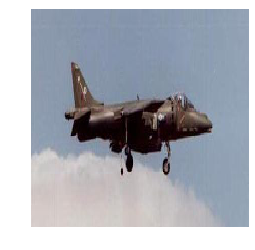

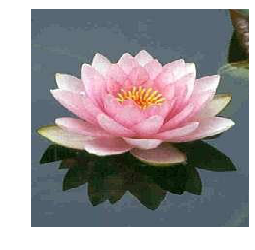

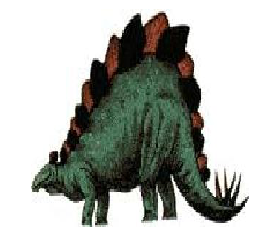

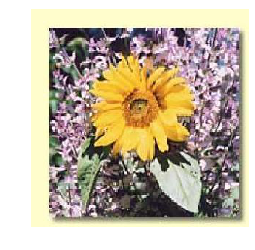

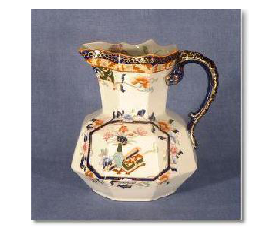

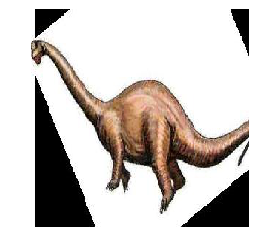

In [23]:
# Visualize the resulting images
#indices = [8194, 8551, 5005, 2166, 2140, 2157]
#indices = [8451, 337, 7316, 323, 7375, 7327]
#indices = [1616, 419, 268, 8382, 8383, 8425]
#indices = [5815, 739, 5497, 7416, 5501, 5365]

indices = [1616, 419, 5005, 8382, 7375, 2157]

for i in indices:
    show_img(X_paths[i])

***

**b)** Looking at the results, what can you say about the "types" of images that obtain good retrieval scores compared to those obtaining poor retrieval scores? Give an explanation and possible solution(s).

(*HINT: How did we obtain data representations for similarity measures?*)

**Answer:**

First of all, we know that the resolution of the images used here is small: 224x224. This means that during analysis of the network, only the bigger features were visible to be analysed. This means that the CNN has only been able to analyze the features that were still visible, which means those with high contrast and sharp edges. This can also be seen in the resulting images printed above. The result with 0 correct neigbors is the plane. Due to low resolution, there are not many edges that indicate this image to be a plane. Most edges to denote the wings and other properties have vanished, and the outline is the most prominent feature visible here. 

In addition, the angle of the image is also not typical for a plane. Normally, one would clearly see wings, and maybe a large number of planes was photographed on the ground. The fact that this is not a typical example of the class makes it more likely that the clustering algorithm was not able to position it correctly.

On the other hand, the image with the highest number of correctly retrieved neigbors is a typical drawing of a dinosaur. The view from the side shows features that are very characteristic. In addition, the contrast is high and there are not many small features that disappeared due to low resolution. The form-factor of a dinosaur is very unique as well, and will not easily be confused with other objects. The white background for the two dinosaurs may have helped in their classification too.

Secondly, we know that VGG16 is pretrained on ImageNet, whereas we are using it to classify images from the Caltech101 set. Typically, training and testing data originate from the same corpus. Here, this is not the case, and the resulting scores may have deteriorated due to this. If the training data consists of only birds, it can recognize features belonging to this category, but not features such as a cat's ears or a dog's tail. It then also fails to correctly analyze the plane, as there are no features it recognizes. It will then put it in the same category as other images it cannot classify, and retrieve neighbors with other classes for a plane image. 

Of course, there are other factors that play a role too. One is the amount of images per class contained in the dataset. If this is low, the chances are much higher that the neighbors are of other classes, due to the fact that a higher percentage of neigbors is part of another class. The same holds when an image is an edge case within a class. Its position within a cluster has a high influence on the number of correct neighbors retrieved. 

In general, as a solution to the classification problem, we would suggest training the network on the same type of images that we test them on. In this case, VGG16 should be trained on the Caltech101 database before analyzing whether the retrieval of neighbors is done correctly.
As for a solution to the problem of resolution, we would suggest to start training with bigger images and relatively small filters, to pick up small details as well. As for the fact that some images are not representative of their class at all, there is no easy solution for that. Training with typical images will not necessarily increase recognition of a-typical images. Training on a-typical images may decrease reliability. The answer may lie in adding more neurons to each convolutional layer, to retrieve more features, both typical and a-typical.





***

### Task 1.3: Subjective evaluation
We will now use the "fc2"-features to do image retrieval for query images from the "BACKGROUND_Google" set from the Caltech101 dataset. These images are not associated to a particular class, so we will evaluate them subjectively instead.

**a)** Find two query images from the "BACKGROUND_Google" class, such that for the first query image relevant/similar images are retrieved (according to your own definition of relevancy/similarity), and for the second image mainly irrelevant/dissimilar images are retrieved. For each of them, visualise its 5 nearest neighbors in the Caltech101 dataset (*so do NOT retrieve images from the "BACKGROUND_Google" class!*), according to the "fc2-features" and L2-distance.

{'umbrella': 1, 'buddha': 1, 'stapler': 1, 'Faces': 1, 'Faces_easy': 1}
Index: [261] retrieved score of: 0
============= original: =============


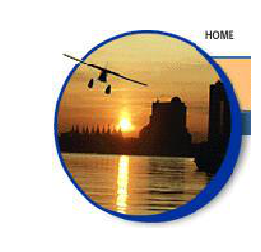

at distance 75.8063634490776:
(Class: umbrella)


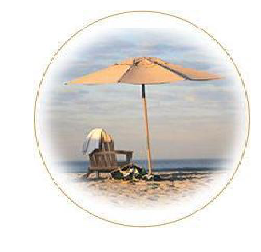

at distance 76.4338552605657:
(Class: buddha)


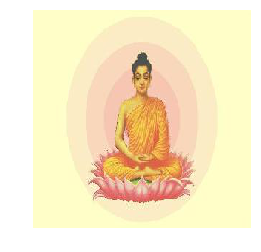

at distance 77.3846262185202:
(Class: stapler)


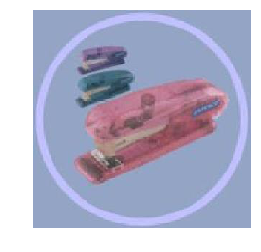

at distance 78.87169835531952:
(Class: Faces)


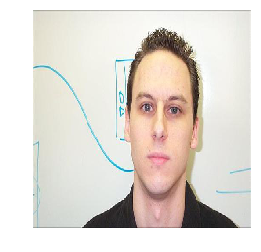

at distance 80.98727325714086:
(Class: Faces_easy)


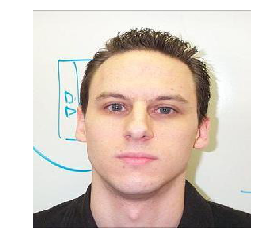

{'joshua_tree': 1, 'buddha': 1, 'pyramid': 1, 'cougar_face': 1, 'bonsai': 1}
{'ferry': 1, 'helicopter': 1, 'airplanes': 1, 'bonsai': 1, 'ceiling_fan': 1}
{'joshua_tree': 5}
Index: [314] retrieved score of: 5
============= original: =============


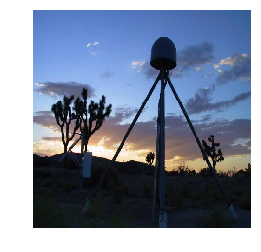

at distance 79.49819302101145:
(Class: joshua_tree)


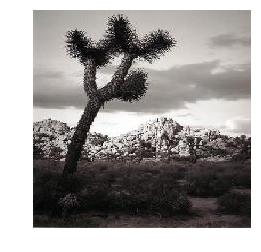

at distance 81.19151436149664:
(Class: joshua_tree)


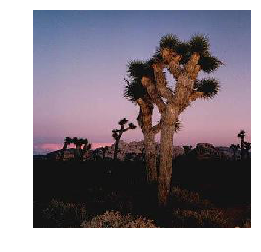

at distance 81.87789833834734:
(Class: joshua_tree)


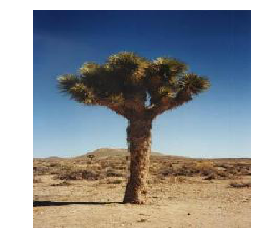

at distance 82.4139222533678:
(Class: joshua_tree)


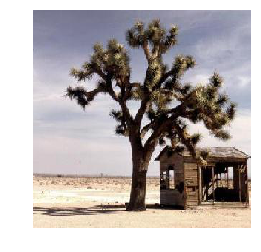

at distance 82.60582750673143:
(Class: joshua_tree)


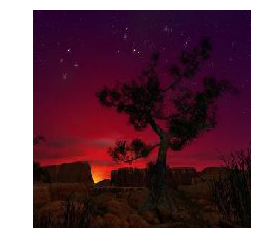

In [47]:
# load the BACKGROUND_Google set
with open(os.path.join("data","caltech101_VGG16_fc2_bg.p"), "rb") as f:
    bg_fc2, bg_paths = pickle.load(f)


    
# === SOLUTION: ===
n_bg_examples = len(bg_paths)
# As the 'original' is not in the dataset already, edit n_neighbors to 5.
neigh = NearestNeighbors(n_neighbors=5, p=2)
# Fit on the caltech101
neigh.fit(X_fc)

def find_bg_Score(index):
    nn = neigh.kneighbors(index)
    scores = {}
    for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
        for dist, j in zip(distances, nn_indices):
            # count the different classes.
            if classes[y[j]] in scores.keys():
                scores[classes[y[j]]] += 1
            else:
                scores[classes[y[j]]] = 1
    # If all are the same, length of scores is 1. If all are different, length of scores is 5.
    if len(scores.keys()) == 1:
        result = 5
        print(scores)
    elif len(scores.keys()) == 5:
        result = 0
        print(scores)
    else:
        result = 1
    return nn, result
 
scores = [0, 5]

while len(scores) > 0: 
    # find a random index
    index = np.random.choice(range(n_bg_examples), size=1, replace=False)
    # Calculate the corresponding score
    X = bg_fc2[index]
    nn, newScore = find_bg_Score(X)
    # If that score was not found already, remove it
    if newScore in scores: 
        scores.remove(newScore)
        print("Index: {} retrieved score of: {}".format(index, newScore))
        print("============= original: =============")
        show_img(bg_paths[index[0]])
        # Print all five neighbors
        for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
            for dist, j in zip(distances, nn_indices):
                print("at distance {}:".format(dist))
                print("(Class: {})".format(classes[y[j]]))
                show_img(X_paths[j])



***

**b)** Motivate your idea of "relevance": why do you consider the results for the first image relevant/similar, and those for the second image irrelevant/dissimilar?

**Answer:**

We based (dis)similarity on the classes of the retrieved Caltech101 images. As the Google Background images do not have class labels, we checked whether the neigboring classes were the same or different. We retrieved one image where all neighbors had the same class, and one where all five had different classes. 

The (dis)similarity is then rooted in the fact that the neighbors displayed here are of the same object or all different objects. For the similar images, we have retrieved a tree from the Background dataset, which has also resulted in the retrieval of trees from the Caltech101 set. The dissimilar set has an original image containing a sunset and a flying plane, with a blue circle around it. It retrieves an umbrella, a buddha, stapler and two faces. These are all very different, in both topic, structure, background and style. They are also definitely unrelated to the original image and therefore irrelevant.

***

**c)** Explain why you think this retrieval method (nearest neighbor for neural codes from VGG16) performs better on the first image than on the second.

**Answer:**

As mentioned before, the performance of a model and the features it can find depend on the data that the network was trained on. The ImageNet dataset presumably contains trees, which means it is relatively easy for the model to correctly classify the tree retrieved from the Background set. The other image is very different. There is no main topic, no big object and no clear features to be analyzed. This means that the model had to work with what it did know. In this case, the yellow color of the sunset seems to have played a big role in finding the neigbors for the image.

***

### Task 1.4: Dimensionality reduction

**a)** So far we've been using 4096-dimensional neural codes. This space is however still quite high-dimensional. Apply a dimensionality reduction method and evaluate the effect on the retrieval performance.

* Use PCA to obtain lower-dimensional representations of the Caltech101 data "fc2"-features (try the same compression rates as in Table 2 of the "Neural Codes for Image Retrieval" paper).
* Evaluate the same retrieval task as explained at the start of this question for each of the compression rates/dimensionalities. Report the retrieval scores.

*HINT: See http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html on how to transform a dataset with PCA.*

In [3]:
# import PCA from scikit-learn
from sklearn.decomposition import PCA

In [57]:
# load the data
datapath = "caltech101_VGG16_fc2.p"
with open(os.path.join("data", datapath), "rb") as f:
    X_fc, y, X_paths, classes = pickle.load(f)
    
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 8677  # the dataset has 8677 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

# === SOLUTION: ===
X_reduced_16 = PCA(n_components=16).fit_transform(X_fc)
X_reduced_32 = PCA(n_components=32).fit_transform(X_fc)
X_reduced_64 = PCA(n_components=64).fit_transform(X_fc)
X_reduced_128 = PCA(n_components=128).fit_transform(X_fc)

dbs = [X_reduced_16, X_reduced_32, X_reduced_64, X_reduced_128, X_fc]
db_names = ["Reduced_16", "Reduced_32", "Reduced_64", "Reduced_128", "Original"]
    
# iterate over two data representations (make sure these two files exist in the "data" subfolder first)
for db in dbs:  
    neigh = NearestNeighbors(n_neighbors=6, p=2)
    neigh.fit(db)
    X = db[indices]
    nn = neigh.kneighbors(X)
    average = 0
    # Iterate over the instances.
    for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
        # Find the original and its properties
        original_class = classes[y[i]]
        # Don't start at zero, because the first neighbor is the original.
        score = -1
        for dist, j in zip(distances, nn_indices):
            if(classes[y[j]] == original_class):
                score += 1
        average = average + score
    average = average/n
    db_name = db_names.pop(0)
    print("Dimensionality: {}, average score: {}".format(db_name, average))


Dimensionality: Reduced_16, average score: 3.595
Dimensionality: Reduced_32, average score: 3.945
Dimensionality: Reduced_64, average score: 4.165
Dimensionality: Reduced_128, average score: 4.135
Dimensionality: Original, average score: 3.965


***

**b)** Discuss your results: how much can you further reduce the dimensionality of the data representations, without affecting the retrieval performance (much)? Compare these results to those from the paper, are your conclusions similar or not?

**Answer:**

For easy comparison, we have not only run the analysis with the four reduced databases, but with the original as well. As can be seen from the results, the databases with dimensionality 64 and 128 perform even better than the model with the original vectors. We therefore could easily reduce the dimensionality to 64, in order to reduce computational load on the system. We could argue that a reduction to 32 dimensions is acceptable too, as the performance is very similar to that of the original model.

Babenko et al. don't take their dimensionality reduction that far, as they decide on reducing to 128 dimensions for PCA. However, in the basics, they do have similar results to ours. For both experiments, the results for 64 and 128 dimensions is similar, with 32 dimensions at a significant distance. Then there is quite a dropoff to the score for 16 dimensions, although the score still seems reasonable. All in all, despite the use of different metrics, we have fairly similar results.

***

## Question 2: Fashion-MNIST (12.5pt)
For this question we will work with the "Fashion-MNIST" dataset. This dataset is modelled to have the same specifics as MNIST; it consists of a training set of 60,000 examples, and a test set of 10,000 examples. Each example is a 28x28 greyscale image, associated with a label from one of 10 classes. The images represent various clothing items (as opposed to handwritten digits for MNIST), each class represents a different type of clothing item. The following classes exist:
* 0:	T-shirt/top
* 1:	Trouser
* 2:	Pullover
* 3:	Dress
* 4:	Coat
* 5:	Sandal
* 6:	Shirt
* 7:	Sneaker
* 8:	Bag
* 9:	Ankle boot

In this question we will investigate various ways to model visual similarity for this dataset, in order to perform image retrieval. For more info about the dataset, see https://github.com/zalandoresearch/fashion-mnist.

The dataset can directly be obtained through Keras:

X_train shape: (60000, 28, 28, 1)
y_train shape: (60000, 10)
X_test shape: (10000, 28, 28, 1)
y_test shape: (10000, 10)


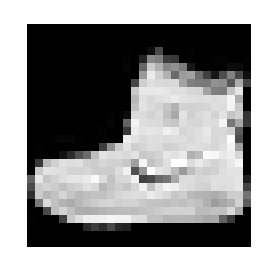

Class: Ankle boot (9)


In [4]:
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
from keras import backend as K

# load the data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# properties of the data
img_rows, img_cols, chns = 28, 28, 1
n_classes = 10

# reshape
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], chns, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], chns, img_rows, img_cols)
    input_shape = (chns, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, chns)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, chns)
    input_shape = (img_rows, img_cols, chns)

# normalise
x_train = x_train.astype("float32")
x_test = x_test.astype("float32")
x_train /= 255
x_test /= 255

# transform labels to one-hot encoding, but also keep original single-digit encoding
y_train_digits = y_train
y_test_digits = y_test
y_train = to_categorical(y_train_digits, n_classes)
y_test = to_categorical(y_test_digits, n_classes)

print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

classes = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

# show an example
example_id = 0  # pick any integer from 0 to 59999 to visualize a training example
example = x_train[example_id].reshape(img_rows, img_cols)
label = y_train[example_id]
label_digit = y_train_digits[example_id]
label_class = classes[label_digit]
plt.matshow(example, cmap="gray")
plt.axis("off")
plt.show()
print("Class: {} ({})".format(label_class, label_digit))

Consider the following situation: We have a fully labelled dataset (the ***labelled set***) of the images from the first 5 classes (t-shirts/tops, trousers, pullovers, dresses, coats). We are then supplied with an unlabelled dataset (the ***retrieval set***) containing the remaining Fashion-MNIST images (sandals, shirts, sneakers, bags, ankle boots) on which we want to be able to perform image retrieval. So we cannot use labels from the retrieval set, since we do not know them (note that in our case we *do* have the labels, but we will only use them for evaluation).

The following code splits the dataset up into two sets representing 5 classes each. Observe that the labelled and the retrieval set have exactly the same size.

In [5]:
# obtain indices of labelled and retrieval sets
indices_train_l = np.argwhere(y_train_digits < 5).flatten()  # indices labelled training set
indices_train_r = np.argwhere(y_train_digits >= 5).flatten()  # indices retrieval training set
indices_test_l = np.argwhere(y_test_digits < 5).flatten()  # indices labelled test set
indices_test_r = np.argwhere(y_test_digits >= 5).flatten()  # indices retrieval test set

# split up train and test set (images and labels)
x_train_l = x_train[indices_train_l]
x_train_r = x_train[indices_train_r]
y_train_l = y_train[indices_train_l]
y_train_r = y_train[indices_train_r]
y_train_digits_l = y_train_digits[indices_train_l]
y_train_digits_r = y_train_digits[indices_train_r]
x_test_l = x_test[indices_test_l]
x_test_r = x_test[indices_test_r]
y_test_l = y_test[indices_test_l]
y_test_r = y_test[indices_test_r]
y_test_digits_l = y_test_digits[indices_test_l]
y_test_digits_r = y_test_digits[indices_test_r]

# labels are now one-hot encoded 10-dimensional vectors, but only the first or last five dimensions are used
# omit unused dimensions to obtain 5-dimensional one-hot encodings
y_train_l = y_train_l[:, :5]
y_train_r = y_train_r[:, 5:]
y_test_l = y_test_l[:, :5]
y_test_r = y_test_r[:, 5:]
# (note that the dimensions of y_train_l/y_test_l do not correspond to those of y_train_r/y_test_r now)

# print the shapes
print(x_train_l.shape)
print(x_train_r.shape)
print(y_train_l.shape)
print(y_train_r.shape)
print(y_train_digits_l.shape)
print(y_train_digits_r.shape)
print(x_test_l.shape)
print(x_test_r.shape)
print(y_test_l.shape)
print(y_test_r.shape)
print(y_test_digits_l.shape)
print(y_test_digits_r.shape)

(30000, 28, 28, 1)
(30000, 28, 28, 1)
(30000, 5)
(30000, 5)
(30000,)
(30000,)
(5000, 28, 28, 1)
(5000, 28, 28, 1)
(5000, 5)
(5000, 5)
(5000,)
(5000,)


***

### Task 2.1: Fashion neural retrieval
**a)** Design an MLP (multilayer perceptron) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use `x_train_l` for training). You may include Dropout and BatchNormalization if needed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train it to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 90%) on the labelled test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [6]:
# import sequential model and layers
from keras.models import Sequential
from keras.layers import Flatten, Dense, Dropout, BatchNormalization

In [13]:
mlp = Sequential()
dropout = 0.35

# === SOLUTION: ===
mlp.add(Dense(32, activation='relu', input_shape=input_shape))
mlp.add(Dropout(dropout))
mlp.add(Dense(64, activation='relu'))
mlp.add(Dropout(dropout))
mlp.add(Flatten())
mlp.add(Dense(128, activation='relu', name="neural_codes"))
mlp.add(Dropout(dropout))
mlp.add(Dense(5, activation='softmax'))

mlp.summary()

mlp.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 28, 28, 32)        64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 32)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 28, 28, 64)        2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
neural_codes (Dense)         (None, 128)               6422656   
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

In [14]:
batch_size = 100
epochs = 20

mlp.fit(x_train_l, y_train_l,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 27000 samples, validate on 3000 samples
Epoch 1/20
27000/27000 [==============================] - 104s 4ms/step - loss: 0.4556 - acc: 0.8307 - val_loss: 0.3356 - val_acc: 0.8737
Epoch 2/20
27000/27000 [==============================] - 103s 4ms/step - loss: 0.3525 - acc: 0.8698 - val_loss: 0.3539 - val_acc: 0.8640
Epoch 3/20
27000/27000 [==============================] - 102s 4ms/step - loss: 0.3290 - acc: 0.8783 - val_loss: 0.2900 - val_acc: 0.8887
Epoch 4/20
27000/27000 [==============================] - 102s 4ms/step - loss: 0.3101 - acc: 0.8857 - val_loss: 0.2740 - val_acc: 0.8947
Epoch 5/20
27000/27000 [==============================] - 102s 4ms/step - loss: 0.2974 - acc: 0.8899 - val_loss: 0.2646 - val_acc: 0.8923
Epoch 6/20
27000/27000 [==============================] - 103s 4ms/step - loss: 0.2847 - acc: 0.8944 - val_loss: 0.2602 - val_acc: 0.8977
Epoch 7/20
27000/27000 [==============================] - 102s 4ms/step - loss: 0.2761 - acc: 0.8977 - val_loss: 0.2736 - v

In [15]:
score = mlp.evaluate(x_test_l, y_test_l, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2610945921421051
Test accuracy: 0.9012


In [16]:
# create directory if doesn't exist yet
try:
    os.mkdir("assignment2_models")
except(FileExistsError):
    pass

# save the model
mlp.save(os.path.join("assignment2_models", "mlp_fashionmnist_l.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

The first attempt was based on several of the practicals of the course.

For the first attempt there were 2 32-dimensional Dense layers and a Dropout with a rate of 0.5 after each. The input was flattened after this, before having a 64-dimensional Dense layer (misread the question) and a Dropout(0.5). The last layer was the 5-dimensional output layer. This gave an accuracy of 88.14%.

The next attempt introduced several BatchNormalization layers to speed up the training speed, and changed the 64-dimensional hidden dense layer to a 128-dimensional hidden dense layer. The training speed was increased significantly, so it was dropped immediately. Without BatchNormalization the training speed was increased again, and a test accuracy of 89.34% was achieved.

The next few iterations included extra hidden dense layers with dimensions between 16 and 64. This gave test set accuracies roughly between 87% and 88%.

The last change to the amount of layers and the dimensions of the hidden dense layers was made, and we ended up with a 32-dimensional hidden dense layer, dropout, 64-dimensional hidden dense layer, dropout, flatten, 128-dimensional hidden dense layer, dropout, 5-dimensional output layer. This gave an accuracy of 89.54%. 

After this the dropout rate was progressively lowered to 0.35, which gave a test accuracy of 90.12%.

***

### Task 2.2: Fashion neural retrieval #2
**a)** Design a CNN (convolutional neural network) for classification on the first 5 classes of the Fashion-MNIST dataset (i.e. only use x_train_l for training), consisting of a number of Convolutions with Max-Pooling, followed by one or more Dense layers. You may use Dropout and BatchNormalization to improve generalization and training speed. Let the last hidden dense layer (before the 5-dimensional output layer) have 128 dimensions. (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later.*)

Train the CNN to classify images into their corresponding classes. Make sure that it achieves decent accuracy (at least 94%) on the test set `x_test_l` (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [7]:
# import additional layers
from keras.layers import Conv2D, MaxPooling2D

In [21]:
cnn = Sequential()

# === SOLUTION: ===
cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))

cnn.add(Flatten())
cnn.add(Dense(128, activation='relu', name="neural_codes"))
cnn.add(BatchNormalization())
cnn.add(Dropout(0.5))
cnn.add(Dense(5, activation='softmax'))

cnn.summary()

cnn.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_4 (Batch (None, 26, 26, 32)        128       
_________________________________________________________________
dropout_7 (Dropout)          (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
dropout_8 (Dropout)          (None, 12, 12, 64)        0         
__________

In [23]:
batch_size = 100
epochs = 20

cnn.fit(x_train_l, y_train_l,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.1)

Train on 27000 samples, validate on 3000 samples
Epoch 1/20
27000/27000 [==============================] - 157s 6ms/step - loss: 0.3710 - acc: 0.8676 - val_loss: 0.3992 - val_acc: 0.8333
Epoch 2/20
27000/27000 [==============================] - 159s 6ms/step - loss: 0.2807 - acc: 0.8998 - val_loss: 0.3094 - val_acc: 0.8823
Epoch 3/20
27000/27000 [==============================] - 158s 6ms/step - loss: 0.2447 - acc: 0.9118 - val_loss: 0.2076 - val_acc: 0.9233
Epoch 4/20
27000/27000 [==============================] - 158s 6ms/step - loss: 0.2233 - acc: 0.9196 - val_loss: 0.1983 - val_acc: 0.9263
Epoch 5/20
27000/27000 [==============================] - 159s 6ms/step - loss: 0.2067 - acc: 0.9249 - val_loss: 0.1812 - val_acc: 0.9347
Epoch 6/20
27000/27000 [==============================] - 159s 6ms/step - loss: 0.1948 - acc: 0.9303 - val_loss: 0.2438 - val_acc: 0.9103
Epoch 7/20
27000/27000 [==============================] - 160s 6ms/step - loss: 0.1888 - acc: 0.9318 - val_loss: 0.1820 - v

In [24]:
loss, accuracy = cnn.evaluate(x_test_l, y_test_l, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.1695358199119568
Test accuracy: 0.9448


In [25]:
# save the model
cnn.save(os.path.join("assignment2_models", "cnn_fashionmnist_l.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

On the first attempt the convolutional network for practical 3.1 was used as basis. This convolutional network already achieved a 94.48% accuracy. BatchNormalization and Dropout with a rate of 0.5 was applied after every convolutional layer. The kernel size of all the convolutional layers is 3x3. The first layer is a 32-dimensioanl convolutional layer. The following layer was a 64-dimensional convolutional layer, after which MaxPooling with a pool size of 2x2 was applied before following with the BatchNormalization and Dropout layer. The input was flattened, and a 128-dimensional hidden dense layer followed and a dropout with a rate of 0.5. Finally the 5-dimensional output layer was the final layer.

***

### Task 2.3: Fashion neural retrieval #3
**a)** Design a (convolutional) Denoising Autoencoder (DAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the DAE to reconstruct noisy images to the original input images. Make sure that it achieves a binary cross-entropy loss of at most 0.29 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [8]:
# import additional layer
from keras.layers import UpSampling2D, Reshape

In [9]:
# obtain noisy version of data
noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

In [27]:
# define autoencoder
dae = Sequential()

# === SOLUTION: ===
# encoder
dae.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
dae.add(MaxPooling2D((2, 2), padding='same'))
dae.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
dae.add(MaxPooling2D((2, 2), padding='same'))
dae.add(Flatten())
dae.add(Dense(128, activation='relu', name="neural_codes"))


# decoder
dae.add(Dense(1568))
dae.add(Reshape((7, 7, 32)))
dae.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
dae.add(UpSampling2D((2, 2)))
dae.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
dae.add(UpSampling2D((2, 2)))
dae.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

dae.summary()
dae.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1568)              0         
_________________________________________________________________
neural_codes (Dense)         (None, 128)               200832    
_________________________________________________________________
dense_6 (Dense)              (None, 1568)              202272    
__________

In [28]:
batch_size = 100
epochs = 10

dae.fit(x_train_noisy, x_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=1/12)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 196s 4ms/step - loss: 0.3357 - val_loss: 0.3057
Epoch 2/10
55000/55000 [==============================] - 193s 4ms/step - loss: 0.2998 - val_loss: 0.2980
Epoch 3/10
55000/55000 [==============================] - 192s 3ms/step - loss: 0.2946 - val_loss: 0.2944
Epoch 4/10
55000/55000 [==============================] - 192s 3ms/step - loss: 0.2918 - val_loss: 0.2927
Epoch 5/10
55000/55000 [==============================] - 193s 4ms/step - loss: 0.2899 - val_loss: 0.2911
Epoch 6/10
55000/55000 [==============================] - 193s 4ms/step - loss: 0.2885 - val_loss: 0.2908
Epoch 7/10
55000/55000 [==============================] - 193s 4ms/step - loss: 0.2874 - val_loss: 0.2892
Epoch 8/10
55000/55000 [==============================] - 193s 4ms/step - loss: 0.2866 - val_loss: 0.2887
Epoch 9/10
55000/55000 [==============================] - 193s 4ms/step - loss: 0.2858 - val_loss: 0.28

In [29]:
test_loss = dae.evaluate(x_test_noisy, x_test, batch_size=batch_size)
print("Test loss:", test_loss)

10000/10000 [==============================] - 10s 961us/step
Test loss: 0.2890214610099793


In [30]:
# save the model
dae.save(os.path.join("assignment2_models", "dae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

On the first attempt the Denoiser Autoencoder of practical 4.1 was used as basis. This convolutional Denoiser Autoencoder achieved a binary cross-entropy loss of 0.288 on the test set. 

The Encoder consisted of two convolutional layers, a 128-dimensional hidden dense layer, the input goes through a MaxPooling layer twice and once through a Flatten layer. There were two 32-dimensional convolutional layers with a kernel size of 3x3, and a MaxPooling with a pool size of 2x2 after each of the convolutional layers. The input was flattened before passing through a 128-dimensional hidden dense layer. 

The Decoder consisted of three convolutional layer, a 1568-dimensional hidden dense layer, a reshape layer, and two UpSampling layers. First the input goes through the 1568-dimensional layer, after which it is reshaped into 7x7x32 3-dimensional intput. The input goes through two 32-dimensional convolutional layers, and the input is UpSampled (2x2) twice after each of the convolutional layer. It is UpSampled to 14x14x32, and eventually 28x28x32 (its original size). The output-layer is a 1-dimensional convolutional layer.

***

Visualise a few test examples, their noisy versions, and their reconstructions.

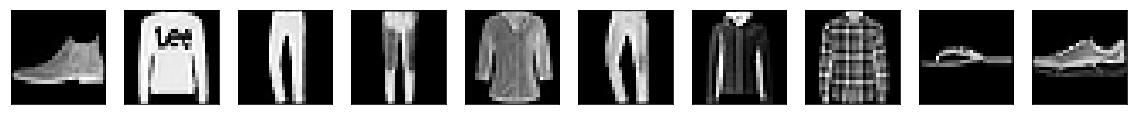

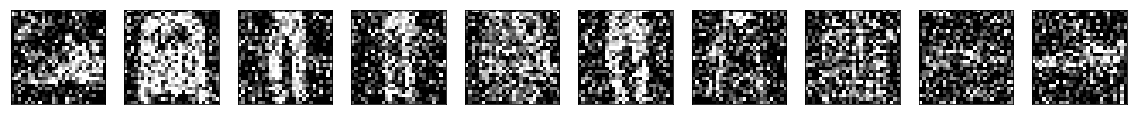

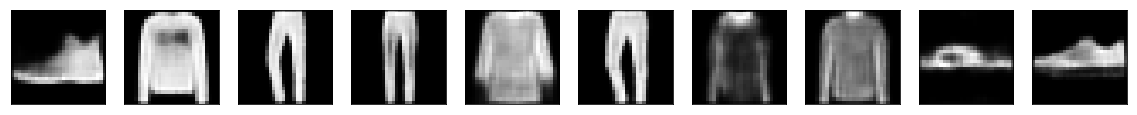

In [31]:
# NOTE: you don't need to change this code, just run it after having trained the DAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr3 = dae.predict(x_test_noisy, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_noisy)
plot_examples(x_test_reconstr3)

**c)** Do you consider the results acceptable? Do you think they can be useful for image retrieval? Explain why in one or two sentences.

**Answer:**

We consider the results acceptable, the images are reconstructed quite well. Details are lost, but this is to be expected with this method. 

The images could be usefull for image retrieval, as clothing for the torse, pants, and shoes are clearly distinguishable. There might be problems when trying to distinguish clothing with the same general shape, e.g. pullover (class 2), coat (class 4), or shirt (class 6). 

***

**d)** Why can we train on the full dataset `x_train` here, whereas in Tasks 2.1 and 2.2 we had to use `x_train_l` (the first 5 classes only) for training?

**Answer:**

In task 2.1 and 2.2 we were training the convolutional network and the multilayer perceptron to classify images, which it hadn't been presented with before, into their corresponding classes. Their corresponding classes are represented by the label of the image, so the labels were necessary to evaluate the performance.

The goal in task 2.3 was to recreate the image as close as possible after downsizing it. The class of the images which are reconstructed are not necessary to perform this task, or evaluate the performance.

***

### Task 2.4: Fashion neural retrieval #4
Autoencoders come in different shapes and sizes. One key defining property of autoencoders is the means the model uses to prevent the learning of the identity function. Typically, this is done with different regularization methods. In the previous task you used a model that uses noise as a regularizer. In this task you will develop a Sparse Autoencoder (SAE). A sparse autoencoder uses a sparsity regularization to obtain sparse representations of the input data. Sparsity can be achieved by using L1-regularization on the activations of the hidden "code" layer.

**a)** Design a (convolutional) Sparse Autoencoder (SAE) for the *full* Fashion-MNIST dataset (i.e. use `x_train`, *not* `x_train_l`). For the encoder, use only Convolutional layers and Max-Pooling, followed by a Dense layer with 128 units. The output of this layer will be the "code" of the autoencoder (*HINT: you can use* `name="neural_codes"` *for this layer to make it easier to obtain features from it later*). Add an activity regularizer to this layer, using `regularizers.l1(10e-5)` from Keras.
For the decoder, start with a Dense layer to upscale to a suitable dimension, and then use only Convolutional layers and UpSampling. You may use BatchNormalization to speed up training.

Train the SAE to reconstruct input images. Make sure that it achieves a loss value of at most 0.31 on the test set (show this!). Save the trained model to a ".h5" file. (make sure you're using Keras version 2.1.3!)

In [10]:
# import regularizers for sparse autoencoder
from keras import regularizers

In [24]:
sae2 = Sequential()

# === SOLUTION: ===
# encoder
sae2.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
sae2.add(MaxPooling2D((2, 2), padding='same'))
sae2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
sae2.add(MaxPooling2D((2, 2), padding='same'))
sae2.add(Flatten())
sae2.add(Dense(128, activation='relu', name="neural_codes", activity_regularizer=regularizers.l1(10e-5)))


# decoder
sae2.add(Dense(1568))
sae2.add(Reshape((7, 7, 32)))
sae2.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
sae2.add(UpSampling2D((2, 2)))
sae2.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
sae2.add(UpSampling2D((2, 2)))
sae2.add(Conv2D(1, (3, 3), activation='sigmoid', padding='same'))

sae2.summary()
sae2.compile(optimizer='adam', loss='binary_crossentropy')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 32)        9248      
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 1568)              0         
_________________________________________________________________
neural_codes (Dense)         (None, 128)               200832    
_________________________________________________________________
dense_5 (Dense)              (None, 1568)              202272    
__________

In [25]:
batch_size = 100
epochs = 10

sae2.fit(x_train, x_train,
                batch_size=batch_size,
                epochs=epochs,
                validation_split=1/12)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 300s 5ms/step - loss: 0.3515 - val_loss: 0.3173
Epoch 2/10
55000/55000 [==============================] - 299s 5ms/step - loss: 0.3098 - val_loss: 0.3077
Epoch 3/10
55000/55000 [==============================] - 300s 5ms/step - loss: 0.3039 - val_loss: 0.3040
Epoch 4/10
55000/55000 [==============================] - 301s 5ms/step - loss: 0.3005 - val_loss: 0.3005
Epoch 5/10
55000/55000 [==============================] - 300s 5ms/step - loss: 0.2976 - val_loss: 0.2982
Epoch 6/10
55000/55000 [==============================] - 300s 5ms/step - loss: 0.2959 - val_loss: 0.2973
Epoch 7/10
55000/55000 [==============================] - 300s 5ms/step - loss: 0.2946 - val_loss: 0.2964
Epoch 8/10
55000/55000 [==============================] - 303s 6ms/step - loss: 0.2935 - val_loss: 0.2950
Epoch 9/10
55000/55000 [==============================] - 319s 6ms/step - loss: 0.2929 - val_loss: 0.29

In [26]:
test_loss = sae2.evaluate(x_test, x_test, batch_size=batch_size)
print("Test loss:", test_loss)

10000/10000 [==============================] - 16s 2ms/step
Test loss: 0.2936955359578133


In [33]:
# save the model
sae2.save(os.path.join("assignment2_models", "sae_fashionmnist.h5"))

***

**b)** Briefly motivate how and why you chose this architecture.

**Answer:**

On the first attempt the Denoiser Autoencoder of task 2.3 was used as basis. This convolutional Denoiser Autoencoder was not adapted except the added line for the activity regulizer. This achieved a test loss of around 0.49. 

For the next attempt, the second convolutional layer was increased to 64 dimensions. The test loss was still around 0.49.

The second convolutional layer was decreased to 32 dimensions for the third and fourth attempt. The third attempt edited the first convolutional layer of the decoder to 64 dimensions, which got a test loss of 0.3032. The fourth attempt edited the second convolutional layer of the decoder (instead of the first) to 64 dimensions, which got a test loss of 0.2937. The fourth attempt was used for all the following tasks.

***

Visualise a few test examples and their reconstructions.

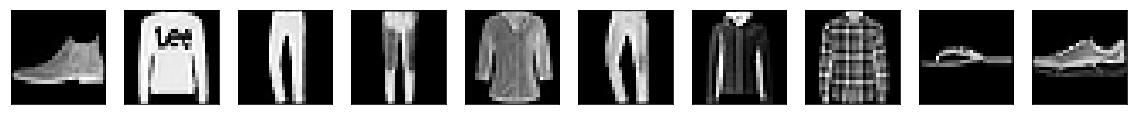

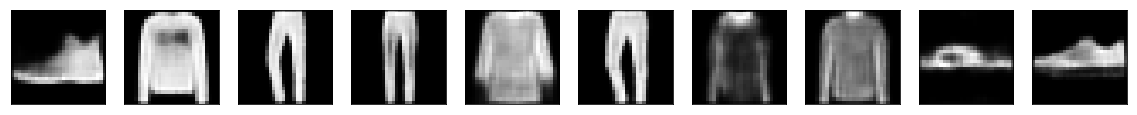

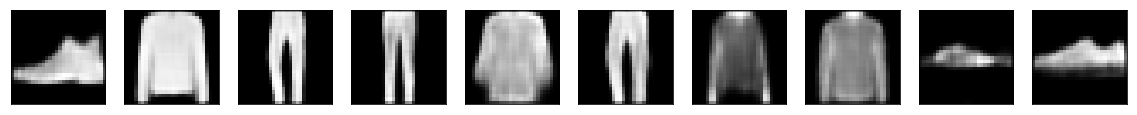

In [34]:
# NOTE: you don't need to change this code, just run it after having trained the SAE
def plot_examples(x):
    n = 10
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i+1)
        plt.imshow(x[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

x_test_reconstr4 = sae2.predict(x_test, batch_size=batch_size)

plot_examples(x_test)
plot_examples(x_test_reconstr3)
plot_examples(x_test_reconstr4)

**c)** Compare the visual results to those of the DAE in Task 2.3. Also compare the loss values of the test set for the DAE and SAE. How can you explain the difference?

**Answer:**

The original images are plotted in the top row, the reconstructed images from the DAE are plotted in the second row, and the reconstructed images from the SAE are plotted in the third row.

It is visible that both the DAE and the SAE were able to retain a lot of information of the original image, and they were both reconstructed quite similarly. The reconstructed images of the DAE have got a little more detail in them, compared to the reconstructed images of SAE. The test loss of the DAE was 0.2890, and the test loss of the SAE was 0.2937, were it's visible that DAE has slightly lower test loss.

***

### Task 2.5: Comparison
Obtain 128-dimensional neural code representations of the last five classes of the Fashion-MNIST dataset (the *retrieval set*: `x_train_r`) from the following models/layers:
1. The last dense hidden layer (before the output layer) of the MLP you trained in Task 2.1
2. The last dense hidden layer (before the output layer) of the CNN you trained in Task 2.2
3. The center layer/code of the DAE you trained in Task 2.3
4. The center layer/code of the SAE you trained in Task 2.4
5. A PCA-transformation

In [35]:
# additional imports
from keras.models import load_model
from keras.models import Model

In [36]:
# load the previously trained and saved models
mlp = load_model(os.path.join("assignment2_models", "mlp_fashionmnist_l.h5"))
cnn = load_model(os.path.join("assignment2_models", "cnn_fashionmnist_l.h5"))
dae = load_model(os.path.join("assignment2_models", "dae_fashionmnist.h5"))
sae = load_model(os.path.join("assignment2_models", "sae_fashionmnist.h5"))
    
# NOTE: change the name "neural codes" if the layer from which you wish to retrieve neural codes has a different name
mlp_nc = Model(inputs=mlp.input, outputs=mlp.get_layer("neural_codes").output)
cnn_nc = Model(inputs=cnn.input, outputs=cnn.get_layer("neural_codes").output)
dae_nc = Model(inputs=dae.input, outputs=dae.get_layer("neural_codes").output)
sae_nc = Model(inputs=sae.input, outputs=sae.get_layer("neural_codes").output)

# obtain flat representations of the data
x_train_r_flat = x_train_r.reshape((x_train_r.shape[0], -1))
x_test_r_flat = x_test_r.reshape((x_test_r.shape[0], -1))

# train PCA on the retrieval set
pca = PCA(n_components=128)
pca.fit(x_train_r_flat)

# obtain 128-dimensional representations
nc_mlp_train = mlp_nc.predict(x_train_r)
nc_mlp_test = mlp_nc.predict(x_test_r)
nc_cnn_train = cnn_nc.predict(x_train_r)
nc_cnn_test = cnn_nc.predict(x_test_r)
nc_dae_train = dae_nc.predict(x_train_r)
nc_dae_test = dae_nc.predict(x_test_r)
nc_sae_train = sae_nc.predict(x_train_r)
nc_sae_test = sae_nc.predict(x_test_r)
nc_pca_train = pca.transform(x_train_r_flat)
nc_pca_test = pca.transform(x_test_r_flat)

# print the shapes to confirm all features are 128-dimensional
print(nc_mlp_train.shape)
print(nc_mlp_test.shape)
print(nc_cnn_train.shape)
print(nc_cnn_test.shape)
print(nc_dae_train.shape)
print(nc_dae_test.shape)
print(nc_sae_train.shape)
print(nc_sae_test.shape)
print(nc_pca_train.shape)
print(nc_pca_test.shape)

(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)
(30000, 128)
(5000, 128)


***

**a)** Evaluate the retrieval task as described in Question 1 on the last 5 classes (the retrieval set) of the Fashion-MNIST dataset, for the five data representations given above. Use query images from the test set and retrieve images from the training set only. Print the five resulting retrieval scores (between 0 and 5).

*HINT: you can use* `y_train_digits_r` *and* `y_test_digits_r` *to obtain digit encodings (as opposed to one-hot encodings) of the data labels.*

In [37]:
# make random selection of n query images/indices, the same for all experiments
n = 200
n_examples = 5000  # the retrieval test set has 5000 images
indices = np.random.choice(range(n_examples), size=n, replace=False)

def show_img(filepath):
    img = image.load_img(filepath, target_size=(224,224))
    plt.imshow(img)
    plt.axis("off")
    plt.show()

representations = [
    (nc_mlp_train, nc_mlp_test),
    (nc_cnn_train, nc_cnn_test),
    (nc_dae_train, nc_dae_test),
    (nc_sae_train, nc_sae_test),
    (nc_pca_train, nc_pca_test),
]
for (nc_train, nc_test) in representations:
    # === SOLUTION: ===   
    neigh = NearestNeighbors(n_neighbors=5, p=2, n_jobs=-1)
    
    #X = nc_train[indices]
    neigh.fit(nc_train)
    
    X = nc_test[indices]
    nn = neigh.kneighbors(X)
    
    average = 0
    
    # Iterate over the instances.
    for i, distances, nn_indices in zip(indices, nn[0], nn[1]):
        
        
        # Find the original and its properties
        original_class_train = y_train_digits_r[i]
        original_class_test = y_test_digits_r[i]
        
        score = 0
        for dist, j in zip(distances, nn_indices):
            if(y_train_digits_r[j] == original_class_test):
                score += 1
        average = average + score
    average = average/n
    print("Average score: {}".format(average))

Average score: 4.44
Average score: 4.53
Average score: 4.655
Average score: 4.53
Average score: 4.68


***

**b)** Compare the "baseline" PCA-transformed data with the other methods. Is PCA a suitable method to obtain representations for image retrieval in this situation? Why do you think so? Would you expect a similar conclusion for the Caltech101 dataset from Question 1?

**Answer:**

The average scores shown above belong from top to bottom to, the multilayer perceptron, the convolutional neural network, DAE, SAE, PCA.

PCA is a suitable method to obtain representations for image retrieval in this situation. The average score for the kNN task shows that PCA performed the best. PCA is a compression method with little loss, it preserves most of the variance within the data which means it is more easily reversible, whereas the other methods are more random.

We would expect similar conclusions for the Calltech101 dataset, as the images in the dataset are more varied. The images in the Calltech101 dataset are larger, and contain colour, instead of just using a greyscale. We expect PCA to better retain the variance within the data, and hence lose less detail.

***

Observe the difference between encodings from the DAE and SAE.

In [38]:
print("Mean activation for DAE encodings:", np.mean(nc_dae_train))
print("Mean activation for SAE encodings:", np.mean(nc_sae_train))

index = 1  # try a few indices here
print("DAE encoding example:")
print(nc_dae_train[index])
print("SAE encoding example:")
print(nc_sae_train[index])

Mean activation for DAE encodings: 0.31755456
Mean activation for SAE encodings: 0.0018689161
DAE encoding example:
[3.1888728  0.         0.         0.         0.59122807 0.
 0.         0.         1.2196757  0.474658   0.         0.6821644
 0.         0.         0.68695605 0.6066267  0.2516683  0.
 0.         0.         0.96612626 0.         0.         0.
 0.         0.         0.73559195 1.0026398  0.5800307  0.
 0.         0.         0.         1.4311452  0.         0.32604304
 0.         0.         0.20221685 0.11244674 0.41684407 0.
 0.         0.         1.2391093  1.3521509  0.         0.
 1.5551618  0.38697356 0.5144719  1.9063313  0.07150897 0.
 0.39871973 0.         0.         0.         0.         1.2762609
 0.         1.2702692  0.         0.10149458 0.         0.
 1.1735903  1.5253093  0.         0.         0.         0.
 0.         0.         0.         0.8430687  0.         0.8315103
 0.         0.         0.         0.6817168  0.         0.
 0.8343529  2.5859478  0.5529

**c)** Discuss the difference in encodings between the two autoencoders (denoising and sparse). Also discuss the difference in retrieval performance for these encodings. How would you explain this difference?

**Answer:**

It is visible in the data encodings that the SAE contains a significant higher amount of zeros. Which you would expect from the encoding of a Sparse Autoencoder, which basically adds a penalty to the loss function so that only a few, large weights are non-zero.

DAE performed better than the SAE, which is visible in the kNN and the reconstructed images comparisons. The data encodings of SAE contain a lot of zeros, so when using kNN to find similar data encodings, kNN will find other data encodings with a lot of zeros. SAE's data encoding all have a lot of zeros in them, so it will be more difficult to find the true nearest neighbor among the others.

***

**d)** What is the best performing method you found in part a)? Describe what advantage you believe this method has over the others.

**Answer:**

PCA performs the best over all others. We believe this is due to the fact that PCA retains the variation within the data, while the other models are more random and don't retain the variation.

MLP is the most simple model, so it doesn't perform well at all compared to the more complex models. MLP was the most difficult to get to the sufficient accuracy of 90%, which was still lower than the accuracy of the CNN. CNN required a higher accuracy of 94%, which was more easy to get with a more complex network. The accuracy is higher, so it also performed better than the MLP model. SAE doesn't perform optimally with the kNN method, while DAE will perform better there.